# Mock Generation Summer 2022
Author: Benjamin Floyd

In [1]:
import json
import emcee
import corner
import glob
import re
import numpy as np
from astropy.table import Table, vstack, join, unique
from astropy.cosmology import FlatLambdaCDM
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from schwimmbad import MultiPool
import astropy.units as u
import pandas as pd
from scipy.special import gamma as gamma_func

%matplotlib inline

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Set up rng
seed = 123
rng = np.random.default_rng(seed)
print(f'Using RNG seed: {seed}')

Using RNG seed: 123


### Mock generation functions

In [2]:
def gamma_point_process(rate: float, weights: float, dx: int, dy: int=None, lower_dx: int=0, lower_dy: int=0):
    if dy is None:
        dy = dx

    # Draw from Gamma distribution with alpha = weights + 1, beta = 1 to determine how many points we will place
    n = stats.gamma(weights + 1, loc=rate * np.abs(dx - lower_dx) * np.abs(dy - lower_dy)).rvs(random_state=rng)
    print(f'{n = }')

    # round and recast as int
    n = int(round(n))

    # Drop `n` points with uniform x and y coordinates
    x = rng.uniform(lower_dx, dx, size=n)
    y = rng.uniform(lower_dy, dy, size=n)

    # Combine the x and y coordinates
    coord = np.vstack((x, y))

    return coord

In [3]:
def poisson_point_process(rate, dx, dy=None, lower_dx=0, lower_dy=0):
    """
    Uses a spatial Poisson point process to generate AGN candidate coordinates.

    Parameters
    ----------
    rate : float
        The model rate used in the Poisson distribution to determine the number of points being placed.
    dx, dy : int, Optional
        Upper bound on x- and y-axes respectively. If only `dx` is provided then `dy` = `dx`.
    lower_dx, lower_dy : int, Optional
        Lower bound on x- and y-axes respectively. If not provided, a default of 0 will be used

    Returns
    -------
    coord : np.ndarray
        Numpy array of (x, y) coordinates of AGN candidates
    """

    if dy is None:
        dy = dx

    # Draw from Poisson distribution to determine how many points we will place.
    p = stats.poisson(rate * np.abs(dx - lower_dx) * np.abs(dy - lower_dy)).rvs(random_state=rng)

    # Drop `p` points with uniform x and y coordinates
    x = rng.uniform(lower_dx, dx, size=p)
    y = rng.uniform(lower_dy, dy, size=p)

    # Combine the x and y coordinates.
    coord = np.vstack((x, y))

    return coord

In [4]:
def weighted_poisson_process(target_rate, weighted_data, selection_threshold, tol, area, dx, **kwargs):
    """
    Generates a poisson point process that incorporates objects with weights assigned to them.

    Parameters
    ----------
    target_rate : float
        The targeted Poisson rate. This will be scaled up to drop the initial sample and will be sampled down to match within the given tolerance.
    weighted_data : array-like, Table, pd.DataFrame
        Data structure containing weights and any other associated data.
    selection_threshold : float
        Selection color threshold corresponding to th 90% purity level being used for this realization.
    tol : float
        Tolerance required to match the sampled weighted rate to the targeted Poisson rate.
    area : float
        Total value of allowable area for objects to be placed.
    dx : int
        Upper bound of x-axis of bounding box used to place points within. If only `dx` is given, then the bounding box is assumed to be square
    **kwargs
        Keyword arguments to be passed to `poisson_point_process`.
    Returns
    -------
    catalog : Table
        Output catalog with positions of objects as well as any associated data corresponding to the weights used.
    """

    # Initial sampling will be well oversampled
    coords = poisson_point_process(target_rate * 100, dx=dx, **kwargs)

    # Populate a DataFrame with the objects
    if isinstance(weighted_data, pd.DataFrame):
        weighted_data_df = weighted_data
    elif isinstance(weighted_data, Table):
        weighted_data_df = weighted_data.to_pandas()
    else:
        weighted_data_df = pd.DataFrame(data=weighted_data)

    weighted_data_df = weighted_data_df.sample(n=coords.shape[-1], replace=True, random_state=rng, weights=f'SELECTION_MEMBERSHIP_{selection_threshold:.2f}')
    weighted_data_table = Table.from_pandas(weighted_data_df)
    weighted_data_table['x'] = coords[0]
    weighted_data_table['y'] = coords[1]
    weighted_data_table['radial_dist'] = np.sqrt((coords[0] - (dx / 2)) ** 2 + (coords[1] - (dx / 2)) ** 2)

    # For now, filter out any object that is outside the range
    weighted_data_table = weighted_data_table[weighted_data_table['radial_dist'] <= 2.5]

    # Iterate through the weighted data and select objects until we overshoot our target rate
    output_data, weights = [], []
    for i, mu in enumerate(weighted_data_table[f'SELECTION_MEMBERSHIP_{selection_threshold:.2f}']):
        proposal = [*weights, mu]
        if np.sum(np.array(proposal) * np.log(target_rate * area)) > target_rate * area:
            output_data.append(weighted_data_table[i])
            weights.append(mu)
            break
        else:
            output_data.append(weighted_data_table[i])
            weights.append(mu)

    # Check the errors for the last and penultimate weights used
    last_err = np.abs(np.sum(np.array(weights) * np.log(target_rate * area)) - target_rate * area)
    prev_err = np.abs(np.sum(np.array(weights[:-1]) * np.log(target_rate * area)) - target_rate * area)

    # Drop the last object if the error is smaller without it.
    if last_err >= prev_err:
        output_data = output_data[:-1]

    # Combine the rows to form an output table
    output_data_table = vstack(output_data)

    # Select only the relevant columns and rename columns for standardization
    output_data_table = output_data_table[
        'x', 'y', 'radial_dist', 'REDSHIFT', 'COMPLETENESS_CORRECTION', f'SELECTION_MEMBERSHIP_{selection_threshold:.2f}']
    output_data_table.rename_columns(['REDSHIFT', f'SELECTION_MEMBERSHIP_{selection_threshold:.2f}'],
                                     ['galaxy_redshift', 'SELECTION_MEMBERSHIP'])
    print(f'Catalog generated with rate: {(final_rate := np.sum(output_data_table["SELECTION_MEMBERSHIP"] * np.log(target_rate * area))):.3f} (target: {target_rate * area:.3f}, error: {np.abs(final_rate - target_rate * area):.3f}) with {len(output_data_table)} objects.')

    return output_data_table

In [5]:
def generate_mock_cluster(cluster_catalog: Table, color_threshold: float, c_true: float, c_true_err: float) -> Table:
    # Background Catalog
    # bkg_cat = weighted_poisson_process(c_true, sdwfs_agn, color_threshold, tol=c_true_err, area=image_width*image_width, dx=image_width)

    bkg_avg_weight = sdwfs_agn[f'SELECTION_MEMBERSHIP_{color_threshold:.2f}'].mean()
    print(f'Generating background with scaled rate: {c_true * bkg_avg_weight:.3f}')

    # Build the background catalog
    bkg_coords = poisson_point_process(c_true, dx=image_width)
    # # bkg_coords = gamma_point_process(c_true, bkg_avg_weight, dx=image_width)
    bkg_cat_df = sdwfs_agn.to_pandas().sample(n=bkg_coords.shape[-1], replace=True, random_state=rng)
    bkg_cat = Table.from_pandas(bkg_cat_df)
    bkg_cat['x'] = bkg_coords[0]
    bkg_cat['y'] = bkg_coords[1]
    bkg_cat['radial_dist'] = np.sqrt((bkg_cat['x'] - (image_width / 2)) ** 2 + (bkg_cat['y'] - (image_width / 2)) ** 2)

    # # For now, filter out any object that is outside the range
    bkg_cat = bkg_cat[bkg_cat['radial_dist'] <= 2.5]

    bkg_cat = bkg_cat['x', 'y', 'radial_dist', 'REDSHIFT', 'COMPLETENESS_CORRECTION', f'SELECTION_MEMBERSHIP_{color_threshold:.2f}']
    bkg_cat.rename_columns(['REDSHIFT', f'SELECTION_MEMBERSHIP_{color_threshold:.2f}'], ['galaxy_redshift', 'SELECTION_MEMBERSHIP'])

    # Add flag to background objects
    bkg_cat['CLUSTER_AGN'] = np.full_like(bkg_cat['x'], False)

    # Cluster Catalog
    # Set an array of radii to generate model rates upon
    r_grid = np.linspace(0., 5., num=100)

    # Find the maximum rate of our model to use to for homogeneous Poisson process (Using c = 0.0 for a cluster-only model)
    max_rate = np.max(model_rate(params=(a_true, beta_true, 0.0), radial_dist=r_grid, cluster_id=-1))

    # For the cluster, we need to select only objects within a redshift range of the cluster redshift.
    sdwfs_agn_at_z = sdwfs_agn[np.abs(sdwfs_agn['REDSHIFT'] - cluster_catalog['REDSHIFT']) <= 0.1]

    cl_avg_weight = sdwfs_agn_at_z[f'SELECTION_MEMBERSHIP_{color_threshold:.2f}'].mean()
    print(f'Generating cluser with scaled rate: {max_rate * cl_avg_weight:.3f}')

    # Generate the homogenous Poisson process (Again, this will need to be done on pixel units in the future.)
    # cl_cat = weighted_poisson_process(max_rate, sdwfs_agn_at_z, color_threshold, tol=c_true_err, area=image_width*image_width, dx=image_width)
    cl_coords = poisson_point_process(max_rate, dx=image_width)
    # # cl_coords = gamma_point_process(max_rate, cl_avg_weight, dx=image_width)
    cl_cat_df = sdwfs_agn_at_z.to_pandas().sample(n=cl_coords.shape[-1], replace=True, random_state=rng)
    cl_cat = Table.from_pandas(cl_cat_df)
    cl_cat['x'] = cl_coords[0]
    cl_cat['y'] = cl_coords[1]
    cl_cat['radial_dist'] = np.sqrt((cl_cat['x'] - (image_width / 2)) ** 2 + (cl_cat['y'] - (image_width / 2)) ** 2)

    # For now, filter out any object that is outside the range
    cl_cat = cl_cat[cl_cat['radial_dist'] <= 2.5]

    cl_cat = cl_cat['x', 'y', 'radial_dist', 'REDSHIFT', 'COMPLETENESS_CORRECTION', f'SELECTION_MEMBERSHIP_{color_threshold:.2f}']
    cl_cat.rename_columns(['REDSHIFT', f'SELECTION_MEMBERSHIP_{color_threshold:.2f}'], ['galaxy_redshift', 'SELECTION_MEMBERSHIP'])

    # Compute model rates at each candidate position
    rate_at_radius = model_rate(params=(a_true, beta_true, 0.), radial_dist=cl_cat['radial_dist'], cluster_id=-1)

    # Perform rejection sampling
    prob_reject = rate_at_radius / max_rate
    alpha = rng.uniform(0., 1., size=len(rate_at_radius))
    cl_cat = cl_cat[prob_reject >= alpha]

    # Add flag to cluster objects
    cl_cat['CLUSTER_AGN'] = np.full_like(cl_cat['x'], True)

    # Merge the catalogs
    los_cat = vstack([cl_cat, bkg_cat])

    # Add a cluster ID
    los_cat['SPT_ID'] = cluster_catalog['SPT_ID']

    # Add a column for the cluster redshift. (Using generic "REDSHIFT" to match real catalog expectation)
    los_cat['REDSHIFT'] = cluster_catalog['REDSHIFT']

    return los_cat

### Generating Model

In [6]:
def model_rate(params, radial_dist, cluster_id):
    """
    Our generating model.

    Parameters
    ----------
    params : tuple of floats
        Tuple of parameters.
    radial_dist : array-like
        A vector of radii of objects relative to the cluster center
    cluster_id : int or str
        Used to select correct background prior

    Returns
    -------
    model : np.ndarray
        A surface density profile of objects as a function of radius.
    """

    # Unpack the parameters
    if cluster_id == -1:
        theta, beta, c0 = params
    else:
        # theta, beta, c0 = (0., 0., *params)
        theta, beta, c0 = params
    rc = rc_true

    # In mock generation, we need to be able to skip adding the background surface density redshift relation.
    if cluster_id == -1:
        cz = 0.
    else:
        z = catalog['REDSHIFT'][catalog['SPT_ID'] == cluster_id][0]
        cz = c0 + delta_c(z) * num_clusters

    # Our amplitude will eventually be more complicated
    a = theta

    # Our model rate is an amplitude of cluster-specific trends with a radial dependence with a constant background rate.
    model = a * (1 + (radial_dist / rc) ** 2) ** (-1.5 * beta + 0.5) + cz

    return model

### Bayesian model functions

In [7]:
def lnlike(params: tuple[float, ...]):
    # Compute the likelihood value for each cluster
    cluster_like = []
    for cluster in catalog.group_by('SPT_ID').groups:
        cluster_id = cluster['SPT_ID'][0]

        # Get the selection membership of each object
        # mu_agn = cluster['SELECTION_MEMBERSHIP']
        mu_agn = 1.

        # Compute the model rate at locations of the AGN.
        ri = cluster['radial_dist']
        ni = model_rate(params, ri, cluster_id)

        # Compute the ideal model rate at continuous locations
        rall = np.linspace(0., 2.5, num=10_000)
        nall = model_rate(params, rall, cluster_id)

        # We use a Poisson likelihood function
        ln_like_func = np.sum(np.log(ni * ri * mu_agn) ) - np.trapz(nall * 2 * np.pi * rall, rall)
        cluster_like.append(ln_like_func)

    # Compute the total likelihood value
    total_ln_like = np.sum(cluster_like)
    return total_ln_like

In [8]:
def lnprior(params: tuple[float, ...]):
    # Extract the parameters
    # theta, beta, c0 = (0., 0., *params)
    theta, beta, c0 = params
    rc = rc_true

    cluster_prior = []
    for cluster in catalog.group_by('SPT_ID').groups:
        # Get the cluster redshift to set the background hyperparameters
        z = cluster['REDSHIFT'][0]
        h_c = agn_prior_surf_den(z) * num_clusters
        h_c_err = agn_prior_surf_den_err(z) * num_clusters

        # Shift background parameter to redshift-dependent value.
        cz = c0 + delta_c(z) * num_clusters

        # Define parameter ranges
        if (0. <= theta <= np.inf and
            -3. <= beta <= 3. and
            0. <= rc <= 0.5 and
            0. <= cz <= np.inf):
            theta_lnprior = 0.
            beta_lnprior = 0.
            rc_lnprior = 0.
            c_lnprior = -0.5 * np.sum((cz - h_c) ** 2 / h_c_err ** 2)
            # c_lnprior = 0.
        else:
            theta_lnprior = -np.inf
            beta_lnprior = -np.inf
            rc_lnprior = -np.inf
            c_lnprior = -np.inf
        ln_prior_prob = theta_lnprior + beta_lnprior + rc_lnprior + c_lnprior
        cluster_prior.append(ln_prior_prob)

    total_lnprior = np.sum(cluster_prior)
    return total_lnprior

In [9]:
def lnprob(params: tuple[float, ...]):
    # Evaluate log-prior and test if we are within bounds
    lp = lnprior(params)

    if not np.isfinite(lp):
        return -np.inf

    return lnlike(params) + lp

## Generate mock catalog

In [10]:
# Select out a number of clusters to use as examples
n_cl = 1

# Read in the SDWFS IRAGN catalog for use later
sdwfs_agn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SDWFS_cutout_IRAGN.fits')

# Read in the SPT cluster catalog. We will use real data to source our mock cluster properties.
Bocquet = Table.read(f'Data_Repository/Catalogs/SPT/SPT_catalogs/2500d_cluster_sample_Bocquet18.fits')

# For the 20 common clusters between SPT-SZ 2500d and SPTpol 100d surveys we want to update the cluster information from
# the more recent survey. Thus, we will merge the SPT-SZ and SPTpol catalogs together.
Huang = Table.read(f'Data_Repository/Catalogs/SPT/SPT_catalogs/sptpol100d_catalog_huang19.fits')

# First we need to rename several columns in the SPTpol 100d catalog to match the format of the SPT-SZ catalog
Huang.rename_columns(['Dec', 'xi', 'theta_core', 'redshift', 'redshift_unc'],
                     ['DEC', 'XI', 'THETA_CORE', 'REDSHIFT', 'REDSHIFT_UNC'])

# Now, merge the two catalogs
SPTcl = join(Bocquet, Huang, join_type='outer')
SPTcl.sort(keys=['SPT_ID', 'field'])  # Sub-sorting by 'field' puts Huang entries first
SPTcl = unique(SPTcl, keys='SPT_ID', keep='first')  # Keeping Huang entries over Bocquet
SPTcl.sort(keys='SPT_ID')  # Resort by ID.

# Convert masses to [Msun] rather than [Msun/1e14]
SPTcl['M500'] *= 1e14
SPTcl['M500_uerr'] *= 1e14
SPTcl['M500_lerr'] *= 1e14

# Remove any unconfirmed clusters
SPTcl = SPTcl[SPTcl['M500'] > 0.0]

# For our masks, we will co-op the masks for the real clusters.
masks_files = [*glob.glob(f'Data_Repository/Project_Data/SPT-IRAGN/Masks/SPT-SZ_2500d/*.fits'),
               *glob.glob(f'Data_Repository/Project_Data/SPT-IRAGN/Masks/SPTpol_100d/*.fits')]

# Make sure all the masks have matches in the catalog
masks_files = [f for f in masks_files if re.search(r'SPT-CLJ\d+-\d+', f).group(0) in SPTcl['SPT_ID']]

# Select a number of masks at random, sorted to match the order in `full_spt_catalog`.
masks_bank = sorted([masks_files[i] for i in rng.choice(n_cl, size=n_cl)],
                    key=lambda x: re.search(r'SPT-CLJ\d+-\d+', x).group(0))

# Find the corresponding cluster IDs in the SPT catalog that match the masks we chose
spt_catalog_ids = [re.search(r'SPT-CLJ\d+-\d+', mask_name).group(0) for mask_name in masks_bank]
spt_catalog_mask = [np.where(SPTcl['SPT_ID'] == spt_id)[0][0] for spt_id in spt_catalog_ids]
selected_clusters = SPTcl['SPT_ID', 'RA', 'DEC', 'M500', 'REDSHIFT', 'REDSHIFT_UNC', 'THETA_CORE', 'XI', 'field'][spt_catalog_mask]

# We'll need the r500 radius for each cluster too.
selected_clusters['R500'] = (3 * selected_clusters['M500'] * u.Msun /
                             (4 * np.pi * 500 *
                              cosmo.critical_density(selected_clusters['REDSHIFT']).to(u.Msun / u.Mpc ** 3))) ** (1 / 3)

# Create cluster names
name_bank = [f'SPT_Mock_{i:03d}' for i in range(n_cl)]

# Combine our data into a catalog
SPT_data = selected_clusters.copy()
SPT_data.rename_columns(['SPT_ID', 'RA', 'DEC'], ['orig_SPT_ID', 'SZ_RA', 'SZ_DEC'])
SPT_data['SPT_ID'] = name_bank
SPT_data['MASK_NAME'] = masks_bank

In [11]:
# Read in the purity and surface density files
with (open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color.json', 'r') as f,
      open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_background_prior_distributions.json', 'r') as g):
    sdwfs_purity_data = json.load(f)
    sdwfs_prior_data = json.load(g)
z_bins = sdwfs_purity_data['redshift_bins'][:-1]
threshold_bins = sdwfs_prior_data['color_thresholds'][:-1]

In [12]:
# Set up interpolators
agn_purity_color = interp1d(z_bins, sdwfs_purity_data['purity_90_colors'], kind='previous')
agn_surf_den = interp1d(threshold_bins, sdwfs_prior_data['agn_surf_den'], kind='previous')
agn_surf_den_err = interp1d(threshold_bins, sdwfs_prior_data['agn_surf_den_err'], kind='previous')

# For convenience, set up the function compositions
def agn_prior_surf_den(redshift: float) -> float:
    return agn_surf_den(agn_purity_color(redshift))

def agn_prior_surf_den_err(redshift: float) -> float:
    return agn_surf_den_err(agn_purity_color(redshift))

# Set up an interpolation for the AGN surface density relative to the reference surface density at z = 0
delta_c = interp1d(z_bins, agn_prior_surf_den(z_bins) - agn_prior_surf_den(0.), kind='previous')

In [13]:
cluster_redshifts = SPT_data['REDSHIFT']
redshift_uncert = SPT_data['REDSHIFT_UNC']

# For a cluster at z = 0.6, the color threshold will be [3.6] - [4.5] = 0.61
color_thresholds = [agn_purity_color(z) for z in cluster_redshifts]

# For now, we will set a fixed window size of 5'x5'. This will need to be generalized to use the mask files' WCS.
image_width = 5.

# We'll boost the number of objects in our sample by duplicating this cluster by a factor.
num_clusters = 50

# We will set our input (true) parameters to be an arbitrary value for cluster and using an approximation of the expected background surface density using our color threshold.
a_true = 2.5
beta_true = 1.0
rc_true = 0.1
c0_true = agn_prior_surf_den(0.)
c_truths = np.array([agn_prior_surf_den(z) for z in cluster_redshifts])
c_err_truths = np.array([agn_surf_den_err(z) for z in cluster_redshifts])

# We will amplify the true parameters by the number of clusters in the sample.
a_true *= num_clusters
c0_true *= num_clusters
c_truths *= num_clusters
c_err_truths *= num_clusters
print(f'Input parameters: {a_true = }, {beta_true = }, {rc_true = }, {c0_true = :.3f} ({c_truths = })')

Input parameters: a_true = 125.0, beta_true = 1.0, rc_true = 0.1, c0_true = 7.905 (c_truths = array([19.86808173]))


### Run cluster realization pipeline

Generating background with scaled rate: 1.390
Generating cluser with scaled rate: 0.618


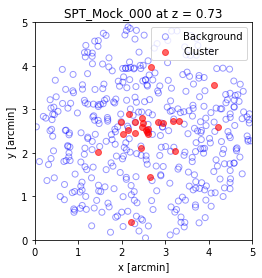

In [14]:
cluster_cats = []
for cluster_catalog, cluster_color_threshold, bkg_rate_true, bkg_rate_err_true in zip(SPT_data, color_thresholds, c_truths, c_err_truths):
    cat = generate_mock_cluster(cluster_catalog, cluster_color_threshold, bkg_rate_true, bkg_rate_err_true)
    cluster_cats.append(cat)

    # Show plot of combined line-of-sight positions
    cluster_objects = cat[cat['CLUSTER_AGN'].astype(bool)]
    background_objects = cat[~cat['CLUSTER_AGN'].astype(bool)]
    _, ax = plt.subplots()
    ax.scatter(background_objects['x'], background_objects['y'], edgecolors='blue', facecolors='none', alpha=0.4, label='Background')
    ax.scatter(cluster_objects['x'], cluster_objects['y'], edgecolors='red', facecolors='red', alpha=0.6, label='Cluster')
    ax.legend()
    ax.set(title=f'{cluster_catalog["SPT_ID"]} at z = {cluster_catalog["REDSHIFT"]:.2f}', xlabel='x [arcmin]', ylabel='y [arcmin]', xlim=[0, image_width], ylim=[0, image_width], aspect=1)
    plt.show()

# Combine all catalogs
master_catalog = vstack(cluster_cats)

In [15]:
cluster_only = master_catalog[master_catalog['CLUSTER_AGN'].astype(bool)]
background_only = master_catalog[~master_catalog['CLUSTER_AGN'].astype(bool)]
len(cluster_only), len(background_only)

(25, 404)

In [16]:
catalog = master_catalog

## Apply Bayesian model to refit data

In [17]:
# Set up walkers
ndim = 3
nwalkers = 50
nsteps = 5000

# Initialize walker positions
# pos0 = np.array([rng.normal(a_true, 1e-4, size=nwalkers), rng.normal(beta_true, 1e-4, size=nwalkers), rng.normal(rc_true, 1e-4, size=nwalkers), rng.normal(c_true, 1e-4, size=nwalkers)]).T
pos0 = np.array([rng.normal(a_true, 1e-4, size=nwalkers), rng.normal(beta_true, 1e-4, size=nwalkers), rng.normal(c0_true, 1e-4, size=nwalkers)]).T
# pos0 = np.array([rng.normal(c0_true, 1e-4, size=nwalkers)]).T

with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=ndim, log_prob_fn=lnprob, pool=pool)
    sampler.run_mcmc(pos0, nsteps=nsteps, progress=True)

try:
    print(f'Mean autocorrelation time: {(mean_tau := np.mean(sampler.get_autocorr_time())):.2f} steps\n', f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}')
except emcee.autocorr.AutocorrError:
    print(f'Mean autocorrelation time: {(mean_tau := np.mean(sampler.get_autocorr_time(quiet=True))):.2f} steps\n', f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}')

100%|██████████| 5000/5000 [01:53<00:00, 44.08it/s]


Mean autocorrelation time: 51.10 steps
 Mean acceptance fraction: 0.619


[Text(0.5, 0, 'Steps')]

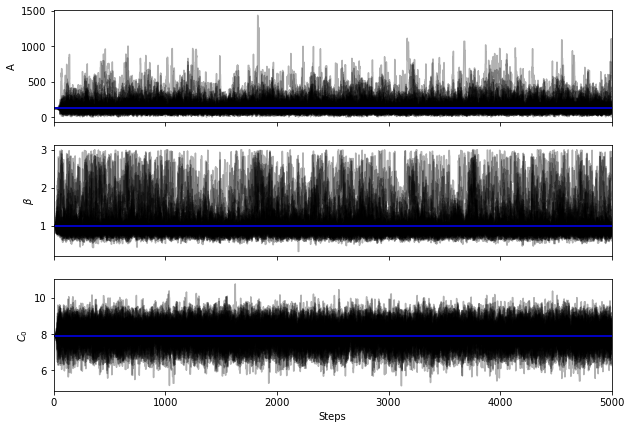

In [18]:
# Plot chains
samples = sampler.get_chain()
labels = ['A', r'$\beta$', r'$C_0$']
truths = [a_true, beta_true, c0_true]
# truth, label = truths[-1], labels[-1]
fig, axes = plt.subplots(nrows=ndim, figsize=(10, 7), sharex='col')
for i, (ax, label, truth) in enumerate(zip(axes.flatten(), labels, truths)):
    ax.plot(samples[:, :, i], 'k', alpha=0.3)
    ax.axhline(y=truth, c='b')
    ax.set(ylabel=label, xlim=[0, len(samples)])
axes[-1].set(xlabel='Steps')
# fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/MCMC/Mock_Catalog/Plots/Port_Rebuild_Tests/param_chains_full_los_hard_mu_cut_correction.pdf')

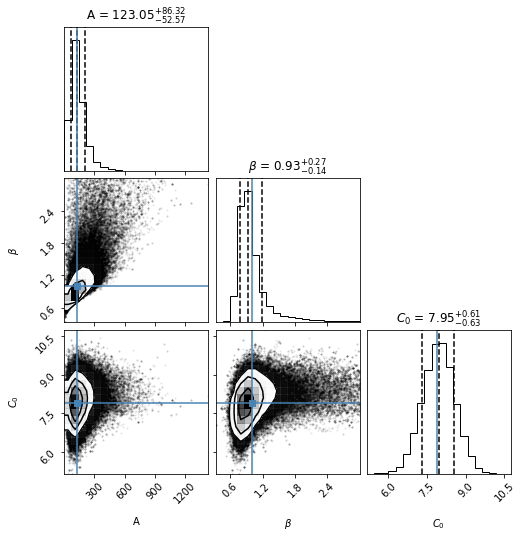

In [19]:
# Plot posterior
flat_samples = sampler.get_chain(discard=int(3*mean_tau), flat=True)
fig = corner.corner(flat_samples, labels=labels, truths=truths, show_titles=True, quantiles=[0.16, 0.5, 0.84])
# fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/MCMC/Mock_Catalog/Plots/Port_Rebuild_Tests/corner_full_los_hard_mu_cut_correction.pdf')

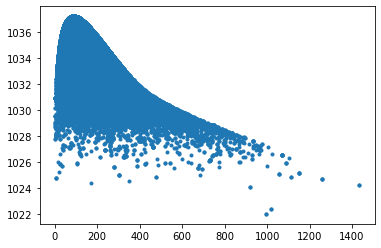

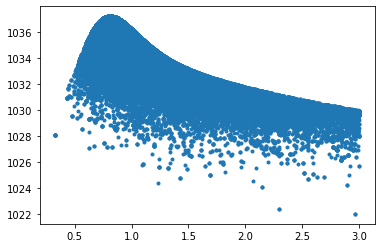

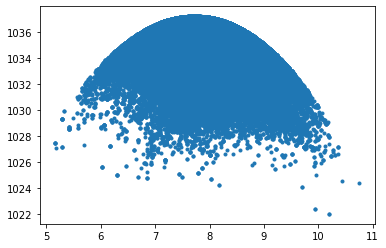

In [20]:
lnpost = sampler.get_log_prob(flat=True, discard=int(3 * mean_tau))
for i in range(flat_samples.shape[-1]):
    plt.plot(flat_samples[:, i], lnpost, '.')
    plt.show()